# The Simpsons classification

## Requirements

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split,Subset
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision.datasets import ImageFolder
from torchmetrics import F1Score
import matplotlib.pyplot as plt
%matplotlib inline

## Hyperparameters and constants

In [2]:
lr = 0.005
batch_size = 32
epochs = 30

class_number = 42
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## NN model

In [3]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())

        self.pool1 = nn.MaxPool2d(2,2)
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=256,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())

        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=512,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())

        self.pool2 = nn.MaxPool2d(2,2)
        
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(512, class_number)

        
        self.train_losses = []
        self.valid_losses = []
        self.test_metrics = []

    def forward(self, input):
        output = self.conv1(input)
        output = self.conv2(output)
        output = self.pool1(output)
        output = self.conv3(output)
        output = self.conv4(output)
        output = self.pool2(output)
        output = self.conv5(output)
        output = self.avg_pool(output)
        output = output.view(-1, 512)
        output = self.fc1(output)
        return output

    def saveModel(self, filename='./simpsons_model.pth'):
        torch.save(obj=self.state_dict(), f=filename)

    def trainStep(self,epoch,optimizer,train_loader,criterion):
        running_loss = 0.0
        avg_f1 = F1Score(task="multiclass", num_classes=class_number).to(device)
        
        for step, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad()
            outputs = self(inputs)
            
            _, predicted = torch.max(outputs.data, 1)                   
            avg_f1.update(predicted,labels)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if step % 100 == 99:
                print(f'[{epoch + 1}, {step + 1:5d}] loss: {loss.item():.3f}')
        
        
        return running_loss,avg_f1.compute()

    
    def validStep(self,valid_loader,criterion):
        running_loss = 0.0
        avg_f1 = F1Score(task="multiclass", num_classes=class_number).to(device)
        
        
        with torch.no_grad():
            for step, data in enumerate(valid_loader, 0):
                inputs, labels = data[0].to(device), data[1].to(device)
                outputs = self(inputs)


                _, predicted = torch.max(outputs.data, 1)                   
                avg_f1.update(predicted,labels)
                
                
                loss = criterion(outputs, labels)
                running_loss += loss.item()
       
        return running_loss,avg_f1.compute() 
        
        
        
    def train(self, optimizer, train_loader,valid_loader, criterion,scheduler ,epochs):
        print('Training started')
        tb = SummaryWriter()
        
        train_step_number = len(train_loader)
        val_step_number = len (valid_loader)
        
        for epoch in range(epochs):
            train_loss, train_f1 = self.trainStep(epoch,optimizer, train_loader, criterion)
            valid_loss, valid_f1 = self.validStep(valid_loader,criterion)     
            
            scheduler.step(valid_loss/val_step_number)
            
            tb.add_scalars(f"Losses",{"Train": train_loss/train_step_number,"Valid": valid_loss/val_step_number }, epoch)
            tb.add_scalars(f"Metrics",{"Train": train_f1,"Valid": valid_f1 }, epoch)
            
            self.train_losses.append(train_loss/train_step_number)
            self.valid_losses.append(valid_loss/val_step_number)
            
            #tb.add_scalar(f"Losses/train",train_loss, epoch)
            #tb.add_scalar(f"Losses/valid",val_loss, epoch)
            
        
        print('Training finished')

    def test(self, test_loader):
        print('Testing started')
        dataiter = iter(test_loader)
        images, labels = next(dataiter)

        avg_f1 = F1Score(task="multiclass", num_classes=class_number).to(device)
        class_f1 =F1Score(task="multiclass", num_classes=class_number,average=None).to(device)
        
        with torch.no_grad():
            for data in test_loader:
                images, labels = data[0].to(device), data[1].to(device)
                
                outputs = self(images)

                _, predicted = torch.max(outputs.data, 1)
                   
                avg_f1.update(predicted,labels)
                class_f1.update(predicted,labels)
                
        self.test_metrics = class_f1.compute() 
        
        print('Testing finished')     
        print(f"F1(average): {avg_f1.compute():.3%}")
        

## Optimizer and Loss function

In [4]:
model = Network()
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=3, verbose=True, threshold=1e-4)

## Data spliting

In [5]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                torchvision.transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]),
                                                torchvision.transforms.Resize((32,32),antialias=True)])
dataset = ImageFolder(
    "The Simpsons Characters Data/simpsons_dataset/simpsons_dataset", transform=transform)

targets = dataset.targets

from sklearn.model_selection import train_test_split

train_idx, test_idx = train_test_split(
    np.arange(len(targets)),
    test_size=0.3,
    shuffle=True,
    stratify=targets
)

train_set = Subset(dataset, train_idx)
tmp_test_set = Subset(dataset, test_idx)


test_targets = list(dataset.targets[i] for i in test_idx)

test_idx, valid_idx = train_test_split(
    np.arange(len(test_targets)),
    train_size=0.5,
    shuffle=True,
    stratify=test_targets
)

test_set = Subset(tmp_test_set, test_idx)
valid_set = Subset(tmp_test_set, valid_idx)

train_loader=torch.utils.data.DataLoader(train_set,batch_size=batch_size, num_workers=4,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=batch_size, num_workers=4,shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set,batch_size=batch_size, num_workers=4,shuffle=True)


## Training

In [6]:
model.train(optimizer,train_loader,valid_loader,criterion,scheduler,epochs)
model.saveModel()

Training started
[1,   100] loss: 2.044
[1,   200] loss: 1.960
[1,   300] loss: 1.375
[1,   400] loss: 1.064
[2,   100] loss: 0.894
[2,   200] loss: 1.182
[2,   300] loss: 0.919
[2,   400] loss: 1.308
[3,   100] loss: 0.664
[3,   200] loss: 0.823
[3,   300] loss: 1.285
[3,   400] loss: 0.795
[4,   100] loss: 0.424
[4,   200] loss: 0.726
[4,   300] loss: 0.304
[4,   400] loss: 0.392
[5,   100] loss: 0.278
[5,   200] loss: 0.558
[5,   300] loss: 0.578
[5,   400] loss: 0.304
[6,   100] loss: 0.144
[6,   200] loss: 0.193
[6,   300] loss: 0.189
[6,   400] loss: 0.483
[7,   100] loss: 0.393
[7,   200] loss: 0.174
[7,   300] loss: 0.237
[7,   400] loss: 0.067
[8,   100] loss: 0.539
[8,   200] loss: 0.171
[8,   300] loss: 0.080
[8,   400] loss: 0.204
[9,   100] loss: 0.295
[9,   200] loss: 0.147
[9,   300] loss: 0.208
[9,   400] loss: 0.222
[10,   100] loss: 0.416
[10,   200] loss: 0.174
[10,   300] loss: 0.426
[10,   400] loss: 0.161
[11,   100] loss: 0.194
[11,   200] loss: 0.065
[11,   300]

Text(0, 0.5, 'Loss')

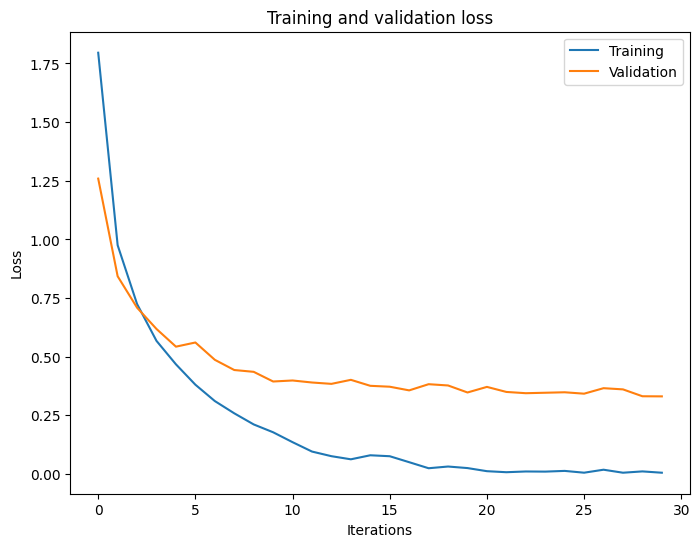

In [7]:
fig = plt.figure(figsize=(8, 6))
plt.plot(model.train_losses,label = 'Training')
plt.plot(model.valid_losses,label = 'Validation')
plt.legend()
plt.title('Training and validation loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')

## Testing

In [8]:
model.test(test_loader)

Testing started
Testing finished
F1(average): 92.648%


<BarContainer object of 42 artists>

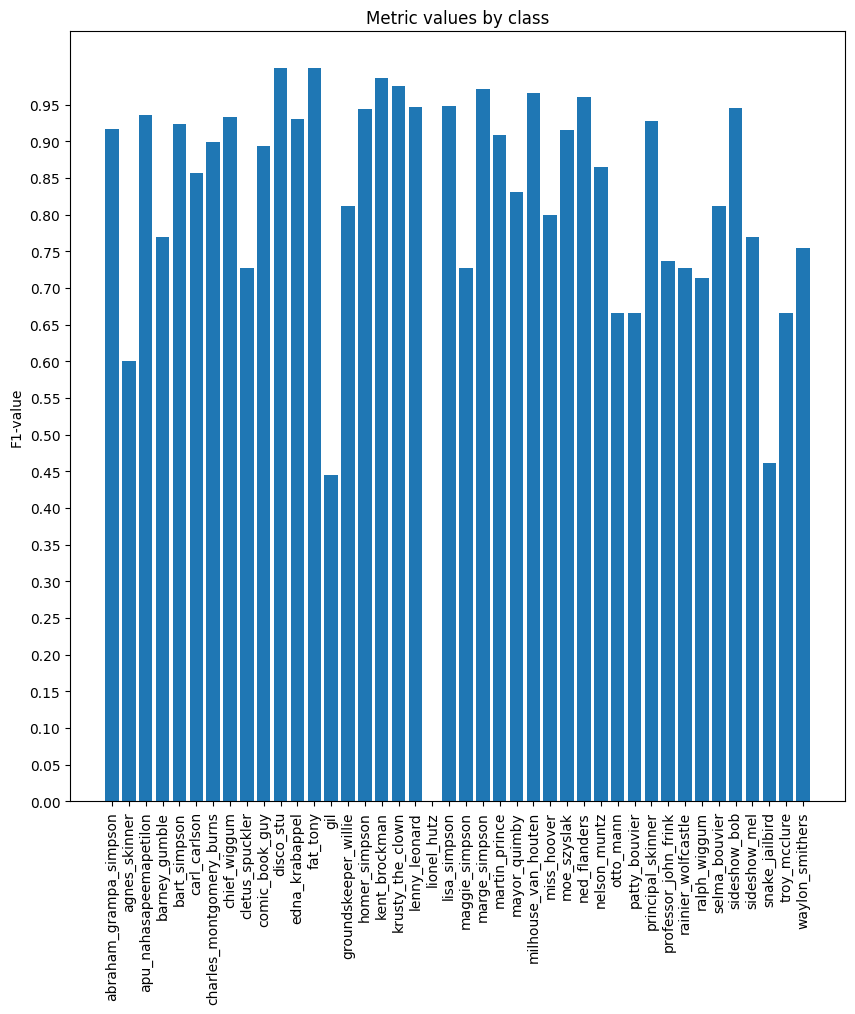

In [9]:
bar = plt.figure(figsize=(10,10))
plt.title("Metric values by class")
plt.ylabel('F1-value')
plt.xticks(rotation=90)
plt.yticks(ticks=np.arange(0, 1.00, 0.05))
plt.bar(dataset.classes, np.array(model.test_metrics.cpu()))